In [1]:
import json
import csv
import os
import os.path as osp
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score

import matplotlib
import matplotlib.pyplot as plt

font = {
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)


In [16]:
def calc_auc(labels, logits):
    fpr, tpr, thres = roc_curve(labels, logits)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thres, roc_auc

def youden_index_stats(fpr, tpr, thres, labels, logits):
    # selecting operating point (Youden Index)
    youden = (1 - fpr) + tpr - 1
    thres_index = np.argmax(youden)
    operating_thres = thres[thres_index]
    
    sen = tpr[thres_index]
    spec = 1 - fpr[thres_index]

    binary_pred = logits >= operating_thres
    hit = binary_pred == labels
    accuracy = np.sum(hit) / hit.shape[0]
    roc_f1_score = f1_score(labels, binary_pred, average='binary')
    ppv = np.sum(binary_pred[labels == 1]) / np.sum(binary_pred == 1)
    npv = np.sum((1 - binary_pred)[labels == 0]) / np.sum(binary_pred == 0)
    
    return accuracy, roc_f1_score, ppv, npv, sen, spec

def plot_roc(ax, fpr, tpr, auc_score, legend_tag='Ours', linecolor='#1f77b4', linewidth=1.0, tag="ROC curve"):
    ax.plot(fpr, tpr, color=linecolor, label=legend_tag, linewidth=linewidth)
    ax.set_xlabel('1 - Specificity', fontsize=20, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=20, fontweight='bold')
    ax.set_title(tag)
    ax.title.set_size(20)
    ax.title.set_weight('bold')
    # ax.legend(loc='lower right')

def calculate_perf(labels, logits):
    fpr, tpr, thres, auc_score = calc_auc(labels, logits)
    acc, f1, ppv, npv, sen, spec = youden_index_stats(fpr, tpr, thres, labels, logits)
    res = {}
    res['fpr'] = fpr
    res['tpr'] = tpr
    res['thres'] = thres
    res['auc_score'] = auc_score
    res['acc'] = acc
    res['f1'] = f1
    res['ppv'] = ppv
    res['npv'] = npv
    res['sen'] = sen
    res['spec'] = spec
    return res
    

#### Read predictions from n-fold cross validation folders

In [17]:
root = "/nas/yirui.wang/exps/Fudan_HN_LN_paper/final_results"
exp = "RUN0"
subfolders = "last_epoch_fuseall/mobilenetv3_large_25d_fudan_hn_ln_bce_loss_dual_maxpool_ENE"
pred_file = "predictions.txt"

cv_image_list = {"internal": [], "external": []}
cv_cls_labels = {"internal": [], "external": []}
cv_cls_logits = {"internal": [], "external": []}
cv_ene_labels = {"internal": [], "external": []}
cv_ene_logits = {"internal": [], "external": []}

for fold in range(5):
    int_image_list, ext_image_list = [], []
    int_cls_labels, ext_cls_labels = [], []
    int_cls_logits, ext_cls_logits = [], []
    int_ene_labels, ext_ene_labels = [], []
    int_ene_logits, ext_ene_logits = [], []
    
    all_predictions = os.path.join(root, exp, "fold{}".format(fold), subfolders, pred_file)
    with open(all_predictions, "r") as f:
        pred_contents = f.read().splitlines()
        
    for row in pred_contents:
        img_name, cls_lab, cls_pred, ene_lab, ene_pred = row.split(',')
        if 'ext_' not in img_name:  # all internal test set
            int_image_list.append(img_name)
            int_cls_labels.append(int(cls_lab))
            int_ene_labels.append((int(ene_lab)))
            int_cls_logits.append(float(cls_pred))
            int_ene_logits.append(float(ene_pred))
        else:
            ext_image_list.append(img_name)
            ext_cls_labels.append(int(cls_lab))
            ext_ene_labels.append((int(ene_lab)))
            ext_cls_logits.append(float(cls_pred))
            ext_ene_logits.append(float(ene_pred))
    
    # sort external test results for ensembling
    sorted_index = np.argsort(ext_image_list)

    cv_image_list['internal'].append(np.array(int_image_list))
    cv_image_list['external'].append(np.array(ext_image_list)[sorted_index])
    cv_cls_labels['internal'].append(np.array(int_cls_labels))
    cv_cls_labels['external'].append(np.array(ext_cls_labels)[sorted_index])
    cv_ene_labels['internal'].append(np.array(int_ene_labels))
    cv_ene_labels['external'].append(np.array(ext_ene_labels)[sorted_index])
    cv_cls_logits['internal'].append(np.array(int_cls_logits))
    cv_cls_logits['external'].append(np.array(ext_cls_logits)[sorted_index])
    cv_ene_logits['internal'].append(np.array(int_ene_logits))
    cv_ene_logits['external'].append(np.array(ext_ene_logits)[sorted_index])
    
# sanity check for the order of external testing set
for i in range(len(cv_image_list['external']) - 1):
    assert (cv_image_list['external'][i] == cv_image_list['external'][i + 1]).all(), "External test order is wrong!"

print("Total {} 5-fold CV testing data".format(sum([len(p) for p in cv_image_list['internal']])))

Total 1889 5-fold CV testing data


In [18]:
def eval_calculation(cls_labels, ene_labels, cls_logits, ene_logits):
    cls_res = calculate_perf(cls_labels, cls_logits)
    # ENE
    ene_res = calculate_perf(ene_labels, ene_logits)
    # Meta-ENE vs meta-none-ENE
    meta_mask = cls_labels == 1
    ene_vs_meta_res = calculate_perf(ene_labels[meta_mask], ene_logits[meta_mask])
    
    return cls_res, ene_res, ene_vs_meta_res
    
def total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=None, tst_type='internal', num_fold=5, draw=False, ensemble=False):
    auc_scores, ene_auc_scores, ene_vs_meta_auc_scores = [], [], []
    # config plt drawing
    if draw and not ensemble:
        fig, ax = plt.subplots(1, num_fold, figsize=(8*num_fold, 6))
    elif draw and ensemble:
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        
    if ensemble:
        assert tst_type == 'external', "Ensemble only works for external testing set!"
        cv_cls_logits = np.mean(np.stack(cv_cls_logits[tst_type]), axis=0)
        cv_ene_logits = np.mean(np.stack(cv_ene_logits[tst_type]), axis=0)
        cv_cls_labels = cv_cls_labels[tst_type][0]
        cv_ene_labels = cv_ene_labels[tst_type][0]
        num_fold = 1
        
        
    for i in range(num_fold):
        if sel_mask is None:
            mask = np.ones_like(cv_cls_labels[tst_type][i], dtype=bool).tolist()
        else:
            mask = sel_mask
            
        if not ensemble:
            fold_cls_labels = cv_cls_labels[tst_type][i][mask]
            fold_ene_labels = cv_ene_labels[tst_type][i][mask]
            fold_cls_logits = cv_cls_logits[tst_type][i][mask]
            fold_ene_logits = cv_ene_logits[tst_type][i][mask]
        else:
            fold_cls_labels = cv_cls_labels[mask]
            fold_ene_labels = cv_ene_labels[mask]
            fold_cls_logits = cv_cls_logits[mask]
            fold_ene_logits = cv_ene_logits[mask]
    
        cls_res, ene_res, ene_vs_meta_res = eval_calculation(fold_cls_labels,
                                                             fold_ene_labels, 
                                                             fold_cls_logits, 
                                                             fold_ene_logits)
        auc_scores.append(cls_res['auc_score'])
        ene_auc_scores.append(ene_res['auc_score'])
        ene_vs_meta_auc_scores.append(ene_vs_meta_res['auc_score'])
        
        if draw and not ensemble:
            plot_roc(ax[i], cls_res['fpr'], cls_res['tpr'], cls_res['auc_score'], tag="ROC curve", linewidth=3.0)
        elif draw and ensemble:
            plot_roc(ax[0], cls_res['fpr'], cls_res['tpr'], cls_res['auc_score'], 
                     linecolor='black',
                     tag="Metastasis classification ROC curve", 
                     linewidth=3,
                     legend_tag="Ours(AUC={:.4f})".format(cls_res['auc_score']))
            
            ax[0].plot(1. - 0.7926, 0.8455, marker='*', markersize=10, color='red', linestyle = 'None', label="Radiologist-1")
            ax[0].plot(1. - 0.8378, 0.7364, marker='p', markersize=10, color='blue', linestyle = 'None', label="Radiologist-2")
            ax[0].legend(loc='lower right')
            
            plot_roc(ax[1], ene_res['fpr'], ene_res['tpr'], ene_res['auc_score'], 
                     linecolor='black',
                     tag="ENE Vs. All LNs ROC curve", 
                     linewidth=3,
                     legend_tag="Ours(AUC={:.4f})".format(ene_res['auc_score']))
            ax[1].plot(1. - 0.9654, 0.6250, marker='*', markersize=10, color='red', linestyle = 'None', label="Radiologist-1")
            ax[1].plot(1. - 0.9654, 0.6667, marker='p', markersize=10, color='blue', linestyle = 'None', label="Radiologist-2")
            ax[1].legend(loc='lower right')
            
    if draw:
        fig.show()

    print("Averaged classificiton AUC: {:.4f}".format(np.mean(auc_scores)))
    print("Averaged ENE AUC: {:.4f}".format(np.mean(ene_auc_scores)))
    print("Averaged ENE vs Metastasis AUC: {:.4f}".format(np.mean(ene_vs_meta_auc_scores)))

    print("Classification AUC per fold: ", end="")
    for idx, item in enumerate(auc_scores):
        ending = ", " if idx != len(auc_scores) - 1 else "\n"
        print("{:.4f}".format(item), end=ending)
        
    print("ENE Vs. All per fold: ", end="")
    for idx, item in enumerate(ene_auc_scores):
        ending = ", " if idx != len(ene_auc_scores) - 1 else "\n"
        print("{:.4f}".format(item), end=ending)
        
    print("ENE Vs. Meta per fold: ", end="")
    for idx, item in enumerate(ene_vs_meta_auc_scores):
        ending = ", " if idx != len(ene_vs_meta_auc_scores) - 1 else "\n"
        print("{:.4f}".format(item), end=ending)

In [43]:
print("INTERNAL 5-fold CV TEST")
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, tst_type='internal', num_fold=5, draw=False)

INTERNAL 5-fold CV TEST
Averaged classificiton AUC: 0.8898
Averaged ENE AUC: 0.9552
Averaged ENE vs Metastasis AUC: 0.8853
Classification AUC per fold: 0.9160, 0.9185, 0.8783, 0.8431, 0.8933
ENE Vs. All per fold: 0.9827, 0.9575, 0.9035, 0.9544, 0.9779
ENE Vs. Meta per fold: 0.9082, 0.8876, 0.8173, 0.9093, 0.9042


#### External tests

In [44]:
print("Renji EXTERNAL TEST SET")
renji_mask = ['ext_renji' in p for p in cv_image_list['external'][0]]
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=renji_mask, tst_type='external', num_fold=5, draw=False)

print("\nCGMH Larynx EXTERNAL TEST SET")
cgmh_mask = ['ext_cgmh_larynx' in p for p in cv_image_list['external'][0]]
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=cgmh_mask, tst_type='external', num_fold=5, draw=False)

print("\nCGMH Oral EXTERNAL TEST SET")
cgmh_oral_mask = ['ext_cgmh_oral' in p for p in cv_image_list['external'][0]]
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=cgmh_oral_mask, tst_type='external', num_fold=5, draw=False)

print("\nTCGA EXTERNAL TEST SET")
tcga_mask = ['ext_tcga' in p for p in cv_image_list['external'][0]]
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=tcga_mask, tst_type='external', num_fold=5, draw=False)

print("\nCGMH + TCGA EXTERNAL TEST SET")
cgmh_tcga_mask = ['ext_tcga' in p or 'ext_cgmh_larynx' in p for p in cv_image_list['external'][0]]
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=cgmh_tcga_mask, tst_type='external', num_fold=5, draw=False)

Renji EXTERNAL TEST SET
Averaged classificiton AUC: 0.9091
Averaged ENE AUC: 0.9574
Averaged ENE vs Metastasis AUC: 0.8294
Classification AUC per fold: 0.9147, 0.9081, 0.9109, 0.9022, 0.9094
ENE Vs. All per fold: 0.9593, 0.9510, 0.9392, 0.9701, 0.9674
ENE Vs. Meta per fold: 0.8057, 0.8043, 0.8159, 0.8488, 0.8721

CGMH Larynx EXTERNAL TEST SET
Averaged classificiton AUC: 0.8868
Averaged ENE AUC: 0.8978
Averaged ENE vs Metastasis AUC: 0.7600
Classification AUC per fold: 0.9003, 0.8764, 0.8767, 0.8804, 0.9002
ENE Vs. All per fold: 0.9033, 0.9142, 0.8874, 0.9129, 0.8711
ENE Vs. Meta per fold: 0.7652, 0.8217, 0.7391, 0.7261, 0.7478

CGMH Oral EXTERNAL TEST SET
Averaged classificiton AUC: 0.8289
Averaged ENE AUC: 0.7421
Averaged ENE vs Metastasis AUC: 0.5670
Classification AUC per fold: 0.8378, 0.8111, 0.8613, 0.8103, 0.8240
ENE Vs. All per fold: 0.8399, 0.7258, 0.6501, 0.7346, 0.7603
ENE Vs. Meta per fold: 0.6587, 0.5897, 0.5160, 0.5785, 0.4920

TCGA EXTERNAL TEST SET
Averaged classificiton

#### External ensemble tests

Renji EXTERNAL TEST SET
Averaged classificiton AUC: 0.9212
Averaged ENE AUC: 0.9710
Averaged ENE vs Metastasis AUC: 0.8634
Classification AUC per fold: 0.9212
ENE Vs. All per fold: 0.9710
ENE Vs. Meta per fold: 0.8634


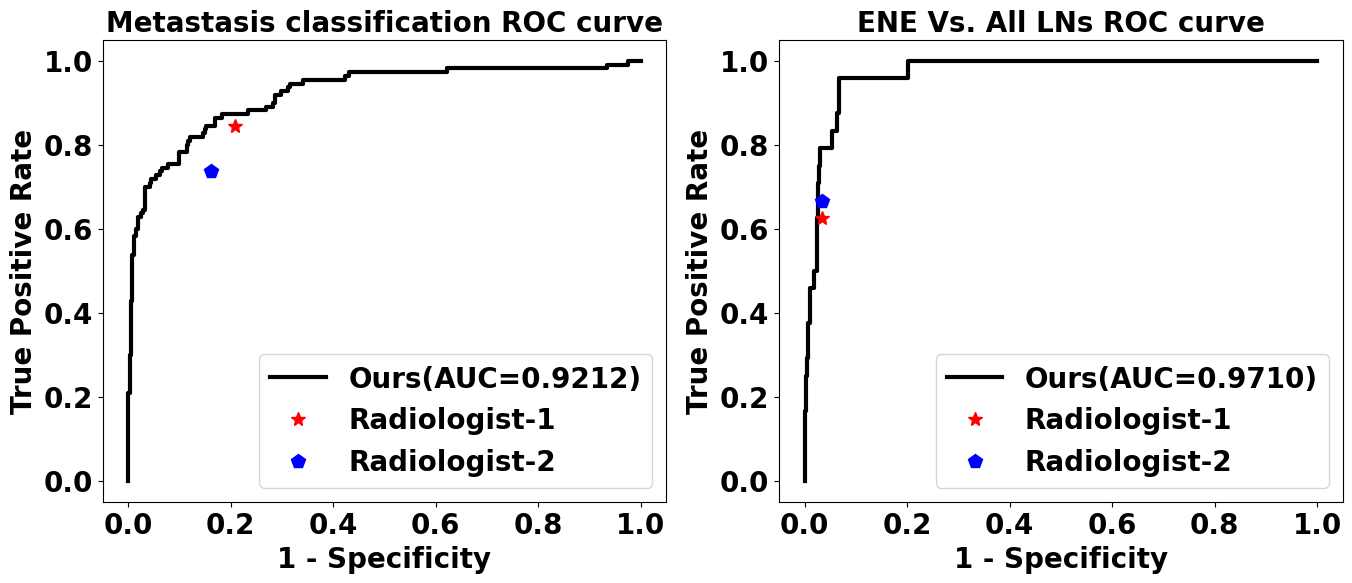

In [45]:
print("Renji EXTERNAL TEST SET")
renji_mask = ['ext_renji' in p for p in cv_image_list['external'][0]]
total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=renji_mask, tst_type='external', num_fold=5, ensemble=True, draw=True)

# print("\nCGMH Larynx EXTERNAL TEST SET")
# cgmh_mask = ['ext_cgmh_larynx' in p for p in cv_image_list['external'][0]]
# total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=cgmh_mask, tst_type='external', num_fold=5, ensemble=True, draw=False)

# print("\nCGMH Oral EXTERNAL TEST SET")
# cgmh_oral_mask = ['ext_cgmh_oral' in p for p in cv_image_list['external'][0]]
# total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=cgmh_oral_mask, tst_type='external', num_fold=5, ensemble=True)

# print("\nTCGA EXTERNAL TEST SET")
# tcga_mask = ['ext_tcga' in p for p in cv_image_list['external'][0]]
# total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=tcga_mask, tst_type='external', num_fold=5, ensemble=True)

# print("\nCGMH + TCGA EXTERNAL TEST SET")
# cgmh_tcga_mask = ['ext_tcga' in p or 'ext_cgmh_larynx' in p for p in cv_image_list['external'][0]]
# total_evaluation(cv_cls_labels, cv_ene_labels, cv_cls_logits, cv_ene_logits, sel_mask=cgmh_tcga_mask, tst_type='external', num_fold=5, ensemble=True)